In [1]:
from dtree import *
from monkdata import *
import drawtree_qt5 as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from IPython.display import display

In [2]:
monk_datasets = [monk1, monk2, monk3]
monk_test_datasets = [monk1test, monk2test, monk3test]
monk_dataset_names = ['Monk1', 'Monk2', 'Monk3']

def partition(data, fraction):
    ldata = list(data)
    random.shuffle(ldata)
    breakPoint = int(len(ldata) * fraction)
    return ldata[:breakPoint], ldata[breakPoint:]

### Assignment 0

### Assignment 1

In [3]:
entropies = []
for ds in monk_datasets:
    entropies.append(entropy(ds))

entropies_df = pd.DataFrame(entropies)
entropies_df.columns = ['Entropy']
entropies_df.index = monk_dataset_names

entropies_df

,Entropy
Monk1,1.000000
Monk2,0.957117
Monk3,0.999806


### Assignment 2

Entropy can be interpreted as the average amount of information in a random variable. It can be interpreted as the number of bits of information in an outcome.

The entropy is at the maximum when the random variable is uniformly distributed, and smaller if it is not uniform.

Since the outcome in the Monk classification is binary, and the entropy of Monk1 is 1, we know that it is uniformly distributed, while Monk2 and Monk3 are not.

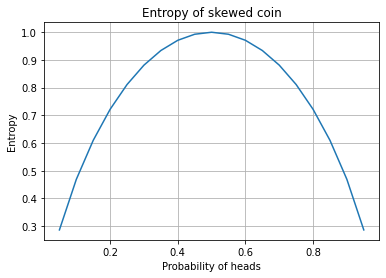

In [4]:
heads_prob = np.arange(0.05, 1.0, 0.05)
entropy = -heads_prob * np.log2(heads_prob) - (1 - heads_prob) * np.log2(1 - heads_prob)

plt.plot(heads_prob, entropy)
plt.grid()
plt.xlabel('Probability of heads')
plt.ylabel('Entropy')
plt.title('Entropy of skewed coin')
plt.show()

### Assignment 3

In [5]:
avg_gains = np.zeros((3, 6))

for i, ds in enumerate(monk_datasets):
    for j, attribute in enumerate(attributes):
        avg_gains[i, j] = averageGain(ds, attribute)

avg_gains_df = pd.DataFrame(avg_gains)
avg_gains_df.columns = ['a1', 'a2', 'a3', 'a4', 'a5', 'a6']
avg_gains_df.index = monk_dataset_names

avg_gains_df

,a1,a2,a3,a4,a5,a6
Monk1,0.075273,0.005838,0.004708,0.026312,0.287031,0.000758
Monk2,0.003756,0.002458,0.001056,0.015664,0.017277,0.006248
Monk3,0.007121,0.293736,0.000831,0.002892,0.255912,0.007077


### Assignment 4

To maximize the information gain the entropy of the subsets after the split need to be minimized, i.e. the subsets need to have zero entropy. This occurs when the samples in each subset only have labels corresponding to a single class.

To obtain the best possible classification, we want to minimize the entropy in the subsets, since this means that the uncertainty is low within the subsets. Therefore, in each step, we want to select the split that reduces the entropy the most.

In [6]:
split_attribute_idx = np.argmax(avg_gains[0, :])
avg_gains_2 = np.zeros((4, 6)) # information gains summarized in second split step
tree_array = [] # nested array keeping track of tree splits

for split_value in range(1, 5):
    selected_split = select(monk1, attributes[split_attribute_idx], split_value)
    

    for j, attribute in enumerate(attributes):
        avg_gains_2[split_value-1, j] = averageGain(selected_split, attribute)

    # Split
    tree_array.append([])
    split_attribute_idx_level_2 = np.argmax(avg_gains_2[split_value-1])
    print(split_attribute_idx_level_2)

avg_gains_2_df = pd.DataFrame(avg_gains_2)

avg_gains_2_df.index = [f"Split {i}" for i in range(1, 5)]
avg_gains_2_df.columns = [i+1 for i in range(6)]

avg_gains_2_df

0
3
5
0


,1,2,3,4,5,6
Split 1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
Split 2,0.040217,0.015063,0.037273,0.048892,0.0,0.025807
Split 3,0.033055,0.002197,0.017982,0.019123,0.0,0.045109
Split 4,0.206291,0.033898,0.025906,0.075933,0.0,0.003324


In [7]:
#limited_tree = buildTree(monk1, attributes, maxdepth=2)
#dt.drawTree(limited_tree)

![Alt text](../tree_sc.png "a title")

### Assignment 5

In [8]:
errors = np.zeros((3,2))

for i, (train_ds, test_ds) in enumerate(zip(monk_datasets, monk_test_datasets)):
    tree = buildTree(train_ds, attributes)

    errors[i, 0] = 1 - check(tree, train_ds)
    errors[i, 1] = 1 - check(tree, test_ds)

errors_df = pd.DataFrame(errors)
errors_df.columns = ['Train error', 'Test error']
errors_df.index = monk_dataset_names

errors_df

,Train error,Test error
Monk1,0.0,0.171296
Monk2,0.0,0.307870
Monk3,0.0,0.055556


On all the datasets we are getting 0% error on the training data. This is because we have not limited the tree depth which means the trees will continue to grow until perfect classification is achieved on the training data. This, of course, leads to overfitting issues which is apparent because of the low bias and high variance.

TODO: Assumptions about assignment 0 correct??

### Assignment 6

In [9]:
def prune_tree(tree, val):
    prev_accuracy = check(tree, val)

    while True:
        alternatives = allPruned(tree)

        best_alternative = None
        best_accuracy = 0

        for alternative in alternatives:
            alt_accuracy = check(alternative, val)
            if alt_accuracy > best_accuracy:
                best_alternative = alternative
                best_accuracy = alt_accuracy

        if best_alternative == None or best_accuracy < prev_accuracy:
            break
        
        prev_accuracy = best_accuracy
        tree = best_alternative
    return tree


def prune_error_rates(dataset_indexes, fraction):
    '''
    For each of the datasets inputed, calculate test set error rate with and without pruning,
    for some fraction of the training data for training/validation
    '''
     # For each dataset, create a row with error rate on test set, with and without pruning
    errors = np.zeros((len(dataset_indexes), 2))
    # Select the correct datasets
    datasets = [monk_datasets[i] for i in dataset_indexes] 
    test_datasets = [monk_test_datasets[i] for i in dataset_indexes]
    
    # For each of the selected dataset, compute and save the error rate, with and without pruning
    for i, (train_ds, test_ds) in enumerate(zip(datasets, test_datasets)):
        monk_train, monk_validate = partition(train_ds, fraction)
        tree = buildTree(monk_train, attributes)
        errors[i, 0] = 1 - check(tree, test_ds)
        # Commenting out code under this doesnt change result???
        pruned_tree = prune_tree(tree, monk_validate)
        errors[i, 1] = 1 - check(pruned_tree, test_ds)

    # Return error matrix
    return errors


errors = prune_error_rates([0, 1, 2], 0.6)

errors_df = pd.DataFrame(errors)
errors_df.columns = ['Before pruning', 'After pruning']
errors_df.index = monk_dataset_names

errors_df

,Before pruning,After pruning
Monk1,0.157407,0.166667
Monk2,0.393519,0.328704
Monk3,0.152778,0.027778


As we discussed earlier, without pruning, this model is prone to overfitting. It makes a very complex model that achieves 100% accuracy on training data, but bad accuracy on the test data. In other words, the bias is low and the variance is high.

With pruning, the complexity of the model is decreased. This improves test data performance by reducing overfitting to the test data. The bias increases slightly, but the variance is decreased.

### Assignment 7

In [41]:
# Fractions to include
fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Number of calculations per fraction
N = 1000

errors = np.zeros((2, len(fractions)))
std = np.zeros((2, len(fractions)))

for i, fraction in enumerate(fractions):
  # Placeholder for result, before average is calculated
  error_values = []

  for _ in range(N):
    inst_err = prune_error_rates([0, 2], fraction)
    error_values.append(inst_err[:, [1]])

  error_values = np.squeeze(np.array(error_values))
  error_means = np.mean(error_values, axis=0)
  error_std = np.std(error_values, axis=0)

  # Add to list
  errors[:, i] = error_means
  std[:, i] = error_std


<function matplotlib.pyplot.show(close=None, block=None)>

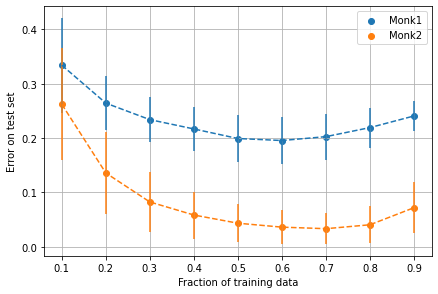

In [44]:
plt.scatter(fractions, errors[0, :], label="Monk1")
plt.scatter(fractions, errors[1, :], label='Monk2')

plt.errorbar(fractions, errors[0, :], std[0, :], linestyle="--")
plt.errorbar(fractions, errors[1, :], std[1, :], linestyle="--",)
plt.legend()
plt.grid()
plt.tight_layout()

plt.xlabel("Fraction of training data")
plt.ylabel("Error on test set")

plt.show